<a href="https://colab.research.google.com/github/urenajose/DS-Unit-2-Applied-Modeling/blob/master/DS_Unit_231_ACC_Shelter_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data set selected for unit 2


##dependencies

In [307]:
%%capture
import sys

In [308]:
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*

In [309]:
pip install eli5

In [310]:
import pandas as pd
import numpy as np

In [311]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [312]:
pip install pdpbox

In [313]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =72

In [314]:
from pdpbox.pdp import pdp_isolate, pdp_plot

## Shelter

In [315]:
df_shelter = pd.read_csv('https://raw.githubusercontent.com/urenajose/DS-Unit-2-Applied-Modeling/master/aac_shelter_outcomes.csv')

In [316]:
display(df_shelter.sample(10))

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
31462,2 months,A736039,Cat,Siamese Mix,Flame Point,2016-08-03T00:00:00,2016-10-04T00:00:00,2016-10-04T00:00:00,NaN,Partner,Transfer,Intact Male
29308,1 year,A733348,Dog,Rat Terrier Mix,Tricolor,2015-08-20T00:00:00,2016-08-24T17:11:00,2016-08-24T17:11:00,NaN,NaN,Adoption,Neutered Male
31257,1 year,A738253,Cat,Domestic Shorthair Mix,Brown Tabby,2015-11-11T00:00:00,2017-01-20T12:54:00,2017-01-20T12:54:00,*Libby,NaN,Adoption,Spayed Female
41137,5 years,A726695,Cat,Domestic Shorthair Mix,Orange Tabby/White,2011-05-13T00:00:00,2016-06-26T21:56:00,2016-06-26T21:56:00,Molly,NaN,Adoption,Spayed Female
71210,1 year,A742811,Other,Rabbit Sh Mix,Blue,2016-01-28T00:00:00,2017-02-08T18:40:00,2017-02-08T18:40:00,*Thumper,NaN,Adoption,Neutered Male
4694,8 months,A683955,Dog,Pointer Mix,Black/White,2013-11-17T00:00:00,2014-07-21T16:51:00,2014-07-21T16:51:00,Pancho,NaN,Return to Owner,Neutered Male
23802,2 months,A698457,Dog,Great Pyrenees,White,2014-12-28T00:00:00,2015-03-14T16:35:00,2015-03-14T16:35:00,Andre,Partner,Transfer,Intact Male
9971,2 months,A691502,Dog,Chihuahua Shorthair Mix,Tan/White,2014-09-05T00:00:00,2014-11-09T18:05:00,2014-11-09T18:05:00,Milo,NaN,Adoption,Neutered Male
34858,4 years,A735129,Dog,Pit Bull Mix,Black,2012-09-19T00:00:00,2016-10-15T16:37:00,2016-10-15T16:37:00,Spade,NaN,Adoption,Spayed Female
54631,2 months,A733235,Cat,Domestic Shorthair Mix,Torbie,2016-06-30T00:00:00,2016-09-13T13:48:00,2016-09-13T13:48:00,NaN,Foster,Adoption,Spayed Female


In [317]:
df_shelter.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [318]:
df_shelter.breed.value_counts()

Domestic Shorthair Mix                   23335
Pit Bull Mix                              6135
Chihuahua Shorthair Mix                   4733
Labrador Retriever Mix                    4608
Domestic Medium Hair Mix                  2323
                                         ...  
Great Pyrenees/St. Bernard Rough Coat        1
Boxer/Doberman Pinsch                        1
Boxer/Akita                                  1
Dachshund Longhair/Cairn Terrier             1
Collie Smooth/Chow Chow                      1
Name: breed, Length: 2128, dtype: int64

In [319]:
df_shelter.outcome_type.value_counts(dropna=True).index

Index(['Adoption', 'Transfer', 'Return to Owner', 'Euthanasia', 'Died',
       'Disposal', 'Rto-Adopt', 'Missing', 'Relocate'],
      dtype='object')

In [320]:
dict_outcome = {'Adoption':'1', 'Transfer':'1', 'Return to Owner':'1', 'Euthanasia':'0', 'Died':'0','Disposal':'0', 'Rto-Adopt':'1', 'Missing':'1', 'Relocate':'1'}

In [321]:
# dict_outcome = {'Adoption':'Lived', 'Transfer':'Lived', 'Return to Owner':'Lived', 'Euthanasia':'Died', 'Died':'Died','Disposal':'Died', 'Rto-Adopt':'Lived', 'Missing':'Lived', 'Relocate':'Lived'}

In [322]:
df_shelter['Target'] = df_shelter.outcome_type.replace(dict_outcome)

In [323]:
df_shelter.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Target
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,1
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,1
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,0


In [324]:
df_shelter['Target'].value_counts()

1    71177
0     7067
Name: Target, dtype: int64

In [325]:
df_shelter = df_shelter[df_shelter['Target'].notna()] #filter null values from my target

In [326]:
df_shelter.Target.isnull().sum()

0

In [327]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_shelter, minimal=True).to_notebook_iframe()

profile

##Applied-Modeling test


In [328]:
train = df_shelter.drop(['outcome_subtype','outcome_type','date_of_birth','datetime','monthyear'],axis=1)

In [329]:
train, test = train_test_split(train, train_size=0.80,test_size=.20, random_state=42)

In [330]:
X_train_t = train.drop('Target',axis=1)
y_train_t = train['Target']
X_test_t = test.drop('Target',axis=1)
y_test_t = test['Target']

In [331]:
%%time
transformers = make_pipeline(ce.OrdinalEncoder(),
                         SimpleImputer(strategy='most_frequent')
                         )

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.66 ms


In [332]:
%%time
X_train_transformed_t = transformers.fit_transform(X_train_t)
X_test_transformed_t = transformers.transform(X_test_t)




CPU times: user 415 ms, sys: 6.82 ms, total: 422 ms
Wall time: 439 ms


In [333]:
%%time
model = RandomForestClassifier(random_state=0, n_jobs=6,max_depth=30,n_estimators=400,min_samples_leaf=2,max_features='auto',bootstrap=False,min_samples_split=4)
model.fit(X_train_transformed_t, y_train_t)

CPU times: user 1min 10s, sys: 298 ms, total: 1min 11s
Wall time: 36.4 s


##Permutation IMportance

In [334]:
import eli5
from eli5.sklearn import PermutationImportance

In [335]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state = 42)

In [336]:
permuter.fit(X_test_transformed_t, y_test_t)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=30,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=2,
                                                       min_samples_split=4,
                                                       min_weight_fra

In [337]:
eli5.show_weights(permuter,
                  top=None,feature_names=X_train_t.columns.values)

Weight,Feature
0.0430 ± 0.0025,animal_type
0.0192 ± 0.0014,name
0.0132 ± 0.0012,sex_upon_outcome
0.0082 ± 0.0016,breed
0.0037 ± 0.0020,age_upon_outcome
0.0013 ± 0.0008,color
-0.0004 ± 0.0007,animal_id


In [338]:
cross_val_score(model, X_train_transformed_t, y_train_t, cv=3)

array([0.95025162, 0.95025162, 0.9503954 ])

In [339]:
np.array([0.80062305, 0.82175893, 0.81504913]).mean()

0.8124770366666668

##Feature Creation

In [340]:
df_shelter.isnull().sum()

age_upon_outcome        6
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23881
outcome_subtype     42281
outcome_type            0
sex_upon_outcome        1
Target                  0
dtype: int64

In [341]:
df_shelter['Name_known'] = np.where(df_shelter.name.isnull(), 0, 1)

In [342]:
df_shelter['age_upon_outcome'].value_counts(dropna=False)

1 year       14352
2 years      11194
2 months      9213
3 years       5157
3 months      3442
1 month       3341
4 years       2990
5 years       2691
4 months      2425
5 months      1951
6 months      1897
6 years       1810
8 years       1554
7 years       1537
3 weeks       1467
2 weeks       1330
10 months     1203
4 weeks       1193
8 months      1178
10 years      1158
7 months       963
9 years        822
9 months       673
12 years       609
1 weeks        513
11 months      490
11 years       429
1 week         427
13 years       389
14 years       253
3 days         235
2 days         217
15 years       208
1 day          153
6 days         152
4 days         136
5 days         116
16 years       101
0 years         94
5 weeks         61
17 years        58
18 years        26
19 years        13
20 years        12
NaN              6
22 years         4
25 years         1
Name: age_upon_outcome, dtype: int64

In [343]:
df_shelter['age_upon_outcome'].fillna("x x",inplace=True)

In [344]:
df_shelter['age_upon_outcome'][0].split()[0]

'2'

In [345]:
df_shelter['age_upon_outcome'][78252].split()[1]

'years'

In [346]:
z = df_shelter['age_upon_outcome'][0]

In [347]:
z.split()[1] == 'weeks'

True

In [348]:
def gregorian_unit(g):
    '''returns number of days base on gregorian unit'''
    try:
      if g.split()[1] == 'day':
        x = int(g.split()[0])*1
        return x
      elif g.split()[1] == 'days':
        x = int(g.split()[0])*1
        return x
      elif g.split()[1] == 'week':
        x = int(g.split()[0])*7
      elif g.split()[1] == 'weeks':
        x = int(g.split()[0])*7
        return x
      elif g.split()[1] == 'month':
        x = int(g.split()[0])*30
        return x
      elif g.split()[1] == 'months':
        x = int(g.split()[0])*30
        return x
      elif g.split()[1] == 'year':
        x = int(g.split()[0])*365
        return x
      elif g.split()[1] == 'years':
        x = int(g.split()[0])*365
        return x
      else:
        return 0
    except: 
        return 0 
# I did this to convert this string to numbers age_upon_outcome 

In [349]:
df_shelter['age_upon_outcome'][15]

'2 years'

In [350]:
print(gregorian_unit(df_shelter['age_upon_outcome'][15]))

730


In [351]:
df_shelter['age_upon_outcome'].str.find('years') 

0       -1
1       -1
2       -1
3        2
4       -1
        ..
78251   -1
78252    2
78253   -1
78254   -1
78255   -1
Name: age_upon_outcome, Length: 78244, dtype: int64

In [352]:
df_shelter['age_upon_outcome_d'] = [gregorian_unit(d) for d in df_shelter['age_upon_outcome']]

In [353]:
df_shelter.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Target,Name_known,age_upon_outcome_d
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,1,0,14.0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1,1,365.0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1,1,365.0
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,1,1,3285.0
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,0,0,150.0


In [354]:
df_shelter['sex_upon_outcome'].fillna('Unknown',inplace=True)
df_shelter['sex_upon_outcome'].value_counts(dropna=False)

Neutered Male    27783
Spayed Female    25203
Intact Male       9547
Intact Female     9140
Unknown           6571
Name: sex_upon_outcome, dtype: int64

In [355]:
df_shelter['sex_upon_outcome'] = df_shelter['sex_upon_outcome'].str.lower() #make all observation string lower case, makes all text lower case

In [356]:
df_shelter['sex_upon_outcome'].str

In [357]:
import re

In [358]:
male = [bool(re.search(r'\bmale\b', i ,flags=re.IGNORECASE)) for i in df_shelter['sex_upon_outcome']] #serch for exact word return true or false if found
pd.DataFrame({"sex":male}).head()

,sex
0,True
1,False
2,True
3,True
4,False


In [359]:
female = [bool(re.search(r'\bfemale\b', i ,flags=re.IGNORECASE)) for i in df_shelter['sex_upon_outcome']]  #serch for exact word return true or false if found
pd.DataFrame({"sex":female}).head()

,sex
0,False
1,True
2,False
3,False
4,False


In [360]:
df_shelter['sex'] = df_shelter['sex_upon_outcome'].copy()

In [361]:
df_shelter.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,Target,Name_known,age_upon_outcome_d,sex
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,intact male,1,0,14.0,intact male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,spayed female,1,1,365.0,spayed female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,neutered male,1,1,365.0,neutered male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,neutered male,1,1,3285.0,neutered male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,unknown,0,0,150.0,unknown


In [362]:
df_shelter.loc[male, 'sex'] = 'male'

In [363]:
df_shelter.loc[female, 'sex'] = 'female'

In [364]:
# df_shelter.age_upon_outcome_d.value_counts()

In [365]:
df_shelter["age_days_at_intake"] = (pd.to_datetime(df_shelter['datetime'])-pd.to_datetime(df_shelter['date_of_birth'])).dt.days

In [366]:
df_shelter['year_birth'] = pd.to_datetime(df_shelter['date_of_birth']).dt.year
# df_shelter.year_birth.value_counts()

In [367]:
df_shelter['month_birth'] = pd.to_datetime(df_shelter['date_of_birth']).dt.month
# df_shelter.month_birth.value_counts()

In [368]:
df_shelter['year_intake'] = pd.to_datetime(df_shelter['datetime']).dt.year

In [369]:
df_shelter['month_intake'] = pd.to_datetime(df_shelter['datetime']).dt.month

In [370]:
pd.DataFrame({'breed':df_shelter.breed.value_counts()})[pd.DataFrame({'breed':df_shelter.breed.value_counts()})['breed'] < 1000] #value_counts filtering

,breed
Siamese Mix,998
Bat,799
Dachshund Mix,798
Boxer Mix,674
Miniature Poodle Mix,648
...,...
Great Pyrenees/St. Bernard Rough Coat,1
Boxer/Doberman Pinsch,1
Boxer/Akita,1
Dachshund Longhair/Cairn Terrier,1


In [371]:
my_dog = df_shelter.animal_type == 'Dog'
my_dog

0        False
1         True
2         True
3         True
4        False
         ...  
78251     True
78252     True
78253    False
78254     True
78255     True
Name: animal_type, Length: 78244, dtype: bool

In [372]:
df_shelter['selected_breed'] = df_shelter.breed

In [373]:
df_shelter.loc[~my_dog, 'selected_breed'] = 'Non_dog_cat'

In [374]:
my_cat = df_shelter.animal_type == 'Cat'
my_cat

0         True
1        False
2        False
3        False
4        False
         ...  
78251    False
78252    False
78253    False
78254    False
78255    False
Name: animal_type, Length: 78244, dtype: bool

In [375]:
rare_dog = df_shelter.selected_breed.value_counts()[df_shelter.selected_breed.value_counts() < 476].index.values

In [376]:
selected_breed = df_shelter.breed.isin(rare_dog)

In [377]:
df_shelter.loc[selected_breed, 'selected_breed'] = "Rare Dog Mix"

In [378]:
df_shelter.loc[my_cat, 'selected_breed'] = 'Cat'

In [379]:
df_shelter.selected_breed.value_counts()

Cat                          29419
Rare Dog Mix                 22572
Pit Bull Mix                  6133
Chihuahua Shorthair Mix       4733
Labrador Retriever Mix        4607
Non_dog_cat                   4587
German Shepherd Mix           1892
Australian Cattle Dog Mix     1059
Dachshund Mix                  798
Boxer Mix                      674
Miniature Poodle Mix           648
Border Collie Mix              646
Catahoula Mix                  476
Name: selected_breed, dtype: int64

In [380]:
df_shelter.iloc[:,-1:]

,selected_breed
0,Cat
1,Rare Dog Mix
2,Rare Dog Mix
3,Rare Dog Mix
4,Non_dog_cat
...,...
78251,Rare Dog Mix
78252,Rare Dog Mix
78253,Non_dog_cat
78254,Rare Dog Mix


In [381]:
df_shelter.selected_breed.value_counts()

Cat                          29419
Rare Dog Mix                 22572
Pit Bull Mix                  6133
Chihuahua Shorthair Mix       4733
Labrador Retriever Mix        4607
Non_dog_cat                   4587
German Shepherd Mix           1892
Australian Cattle Dog Mix     1059
Dachshund Mix                  798
Boxer Mix                      674
Miniature Poodle Mix           648
Border Collie Mix              646
Catahoula Mix                  476
Name: selected_breed, dtype: int64

In [382]:
df_shelter.columns.values

array(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name',
       'outcome_subtype', 'outcome_type', 'sex_upon_outcome', 'Target',
       'Name_known', 'age_upon_outcome_d', 'sex', 'age_days_at_intake',
       'year_birth', 'month_birth', 'year_intake', 'month_intake',
       'selected_breed'], dtype=object)

In [383]:
df = df_shelter.drop(['outcome_subtype','outcome_type','age_upon_outcome', 'animal_id', 'breed','date_of_birth', 'datetime', 'monthyear','year_intake','month_intake','month_birth','year_birth'],axis=1).copy()

In [384]:
df

,animal_type,name,sex_upon_outcome,Target,Name_known,age_upon_outcome_d,sex,age_days_at_intake,selected_breed
0,Cat,NaN,intact male,1,0,14.0,male,15,Cat
1,Dog,Lucy,spayed female,1,1,365.0,female,366,Rare Dog Mix
2,Dog,*Johnny,neutered male,1,1,365.0,male,429,Rare Dog Mix
3,Dog,Monday,neutered male,1,1,3285.0,male,3300,Rare Dog Mix
4,Other,NaN,unknown,0,0,150.0,unknown,181,Non_dog_cat
...,...,...,...,...,...,...,...,...,...
78251,Dog,NaN,spayed female,1,0,30.0,female,59,Rare Dog Mix
78252,Dog,Max,neutered male,1,1,1095.0,male,1129,Rare Dog Mix
78253,Other,NaN,unknown,0,0,0.0,unknown,365,Non_dog_cat
78254,Dog,NaN,spayed female,1,0,60.0,female,80,Rare Dog Mix


In [385]:
train, test = train_test_split(df, train_size=0.80,test_size=.20, random_state=42)

In [386]:
X_train_t = train.drop('Target',axis=1)
y_train_t = train['Target']
X_test_t = test.drop('Target',axis=1)
y_test_t = test['Target']

##Model

In [387]:
%%time
transformers = make_pipeline(ce.OrdinalEncoder())

CPU times: user 2.96 ms, sys: 0 ns, total: 2.96 ms
Wall time: 2.92 ms


In [388]:
%%time
X_train_transformed_t = transformers.fit_transform(X_train_t)
X_test_transformed_t = transformers.transform(X_test_t)




CPU times: user 205 ms, sys: 2.92 ms, total: 208 ms
Wall time: 212 ms


In [389]:
%%time
model = XGBClassifier(random_state=42, n_jobs=6,n_estimators=100)
model.fit(X_train_transformed_t, y_train_t)

CPU times: user 4.73 s, sys: 83.1 ms, total: 4.81 s
Wall time: 2.66 s


In [390]:
cross_val_score(model, X_train_transformed_t, y_train_t, cv=3).mean()

0.9512740634235962

In [391]:
feature = 'sex_upon_outcome'

In [392]:
isolated = pdp_isolate(model=model,
                       dataset=X_test_transformed_t,
                       model_features = X_test_t.columns,
                       feature=feature)

In [393]:
pd.DataFrame({'Encoder_sex':ce.OrdinalEncoder().fit_transform(X_train_t).sex_upon_outcome,'sex_label':df_shelter['sex_upon_outcome']}).groupby('sex_label').max()

,Encoder_sex
sex_label,
intact female,4.0
intact male,5.0
neutered male,3.0
spayed female,1.0
unknown,2.0


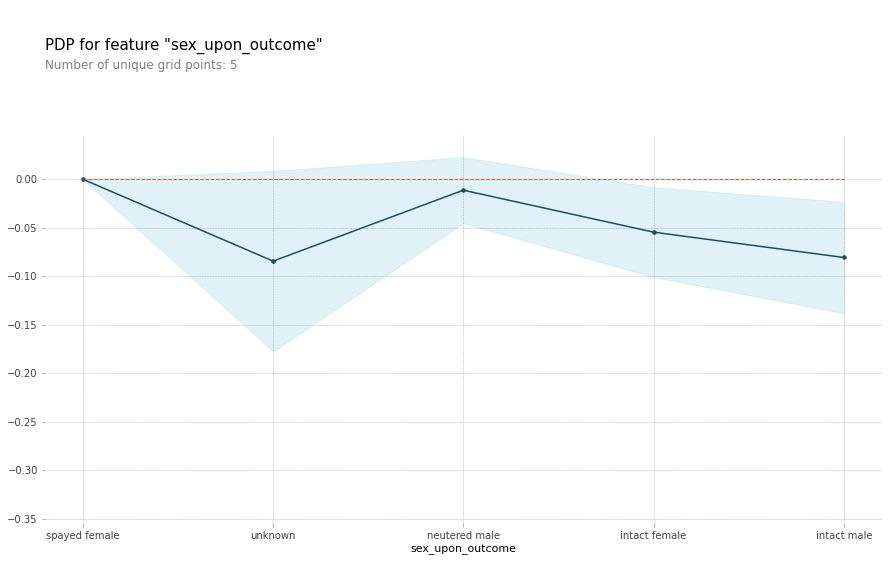

In [394]:
pdp_plot(isolated,feature_name=feature)
plt.xticks([4,5,3,1,2],['intact female','intact male','neutered male','spayed female','unknown'])
plt.show()

In [395]:
X_train_transformed_t.columns

Index(['animal_type', 'name', 'sex_upon_outcome', 'Name_known',
       'age_upon_outcome_d', 'sex', 'age_days_at_intake', 'selected_breed'],
      dtype='object')

In [396]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [397]:
df['selected_breed']

0                           Cat
1                  Rare Dog Mix
2                  Rare Dog Mix
3                  Rare Dog Mix
4                   Non_dog_cat
                  ...          
78251              Rare Dog Mix
78252              Rare Dog Mix
78253               Non_dog_cat
78254              Rare Dog Mix
78255    Labrador Retriever Mix
Name: selected_breed, Length: 78244, dtype: object

In [398]:
pd.DataFrame({'selected_breed_en':ce.OrdinalEncoder().fit_transform(X_train_t).selected_breed,'selected_breed_label':X_train_t.selected_breed}).groupby("selected_breed_label").max()

,selected_breed_en
selected_breed_label,
Australian Cattle Dog Mix,10
Border Collie Mix,11
Boxer Mix,13
Cat,1
Catahoula Mix,12
Chihuahua Shorthair Mix,5
Dachshund Mix,8
German Shepherd Mix,7
Labrador Retriever Mix,4


In [399]:
X_train_t.columns

Index(['animal_type', 'name', 'sex_upon_outcome', 'Name_known',
       'age_upon_outcome_d', 'sex', 'age_days_at_intake', 'selected_breed'],
      dtype='object')

In [411]:
features = ['sex_upon_outcome', 'selected_breed']

In [413]:
interaction = pdp_interact(
    model=model,
    dataset=X_train_transformed_t,
    model_features=X_train_transformed_t.columns,
    features=features
)

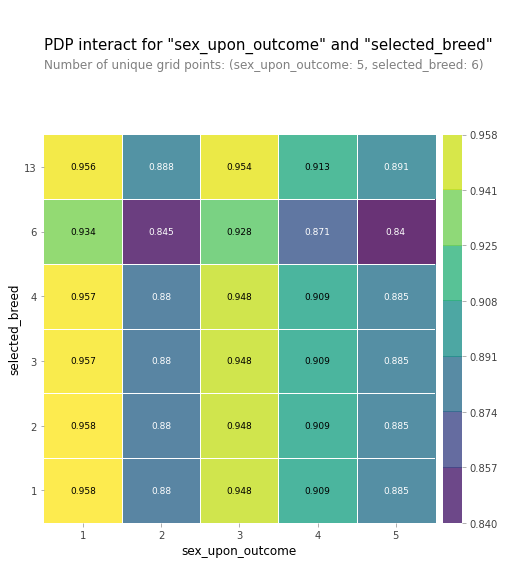

In [414]:
pdp_interact_plot(interaction,plot_type='grid',
                  feature_names=features)
plt.show()